In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [10]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

img_dir = './train1'
categories = ['new_up_2015', 'new_down_2015']
np_classes = len(categories)

image_w = 64
image_h = 64


pixel = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*.png")


    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            #Y는 0 아니면 1이니까 idx값으로 넣는다.
            X.append(data)
            y.append(idx)
            if i % 3000 == 0:
                print(cat, " : ", f)
        except:
            print(cat, str(i)+" 번째에서 에러 ")
X = np.array(X)
Y = np.array(y)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

xy = (X_train, X_test, Y_train, Y_test)
np.save("./numpy_data/binary_image_data.npy", xy)


new_up_2015  :  ./train1/new_up_2015\20150101.PNG
new_down_2015  :  ./train1/new_down_2015\20150104.PNG


In [11]:
import numpy as np
np.version.version

'1.16.1'

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
import numpy as np

X_train, X_test, y_train, y_test = np.load('./numpy_data/binary_image_data.npy')
print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(935, 64, 64, 3)
935
[450 485]
[194 207]


In [13]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3004178121027121856
]


In [14]:
image_w = 64
image_h = 64
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_dir = './model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path = model_dir + "/dog_cat_classify.model"

checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 64)         

In [16]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.15, callbacks=[checkpoint, early_stopping])

Train on 794 samples, validate on 141 samples
Epoch 1/100
794/794 [==============================] - 4s 5ms/step - loss: 0.7001 - accuracy: 0.4874 - val_loss: 0.6912 - val_accuracy: 0.5177

Epoch 00001: val_loss improved from inf to 0.69117, saving model to ./model/dog_cat_classify.model
Epoch 2/100
794/794 [==============================] - 2s 3ms/step - loss: 0.6900 - accuracy: 0.5164 - val_loss: 0.6887 - val_accuracy: 0.5177

Epoch 00002: val_loss improved from 0.69117 to 0.68874, saving model to ./model/dog_cat_classify.model
Epoch 3/100
794/794 [==============================] - 2s 3ms/step - loss: 0.6810 - accuracy: 0.5554 - val_loss: 0.6776 - val_accuracy: 0.5745

Epoch 00003: val_loss improved from 0.68874 to 0.67763, saving model to ./model/dog_cat_classify.model
Epoch 4/100
794/794 [==============================] - 2s 3ms/step - loss: 0.6770 - accuracy: 0.6008 - val_loss: 0.6773 - val_accuracy: 0.5887

Epoch 00004: val_loss improved from 0.67763 to 0.67728, saving model to .

In [17]:
print("정확도 : %.3f " %(model.evaluate(X_test, y_test)[1]))

401/401 [==============================] - 0s 664us/step
정확도 : 0.566 


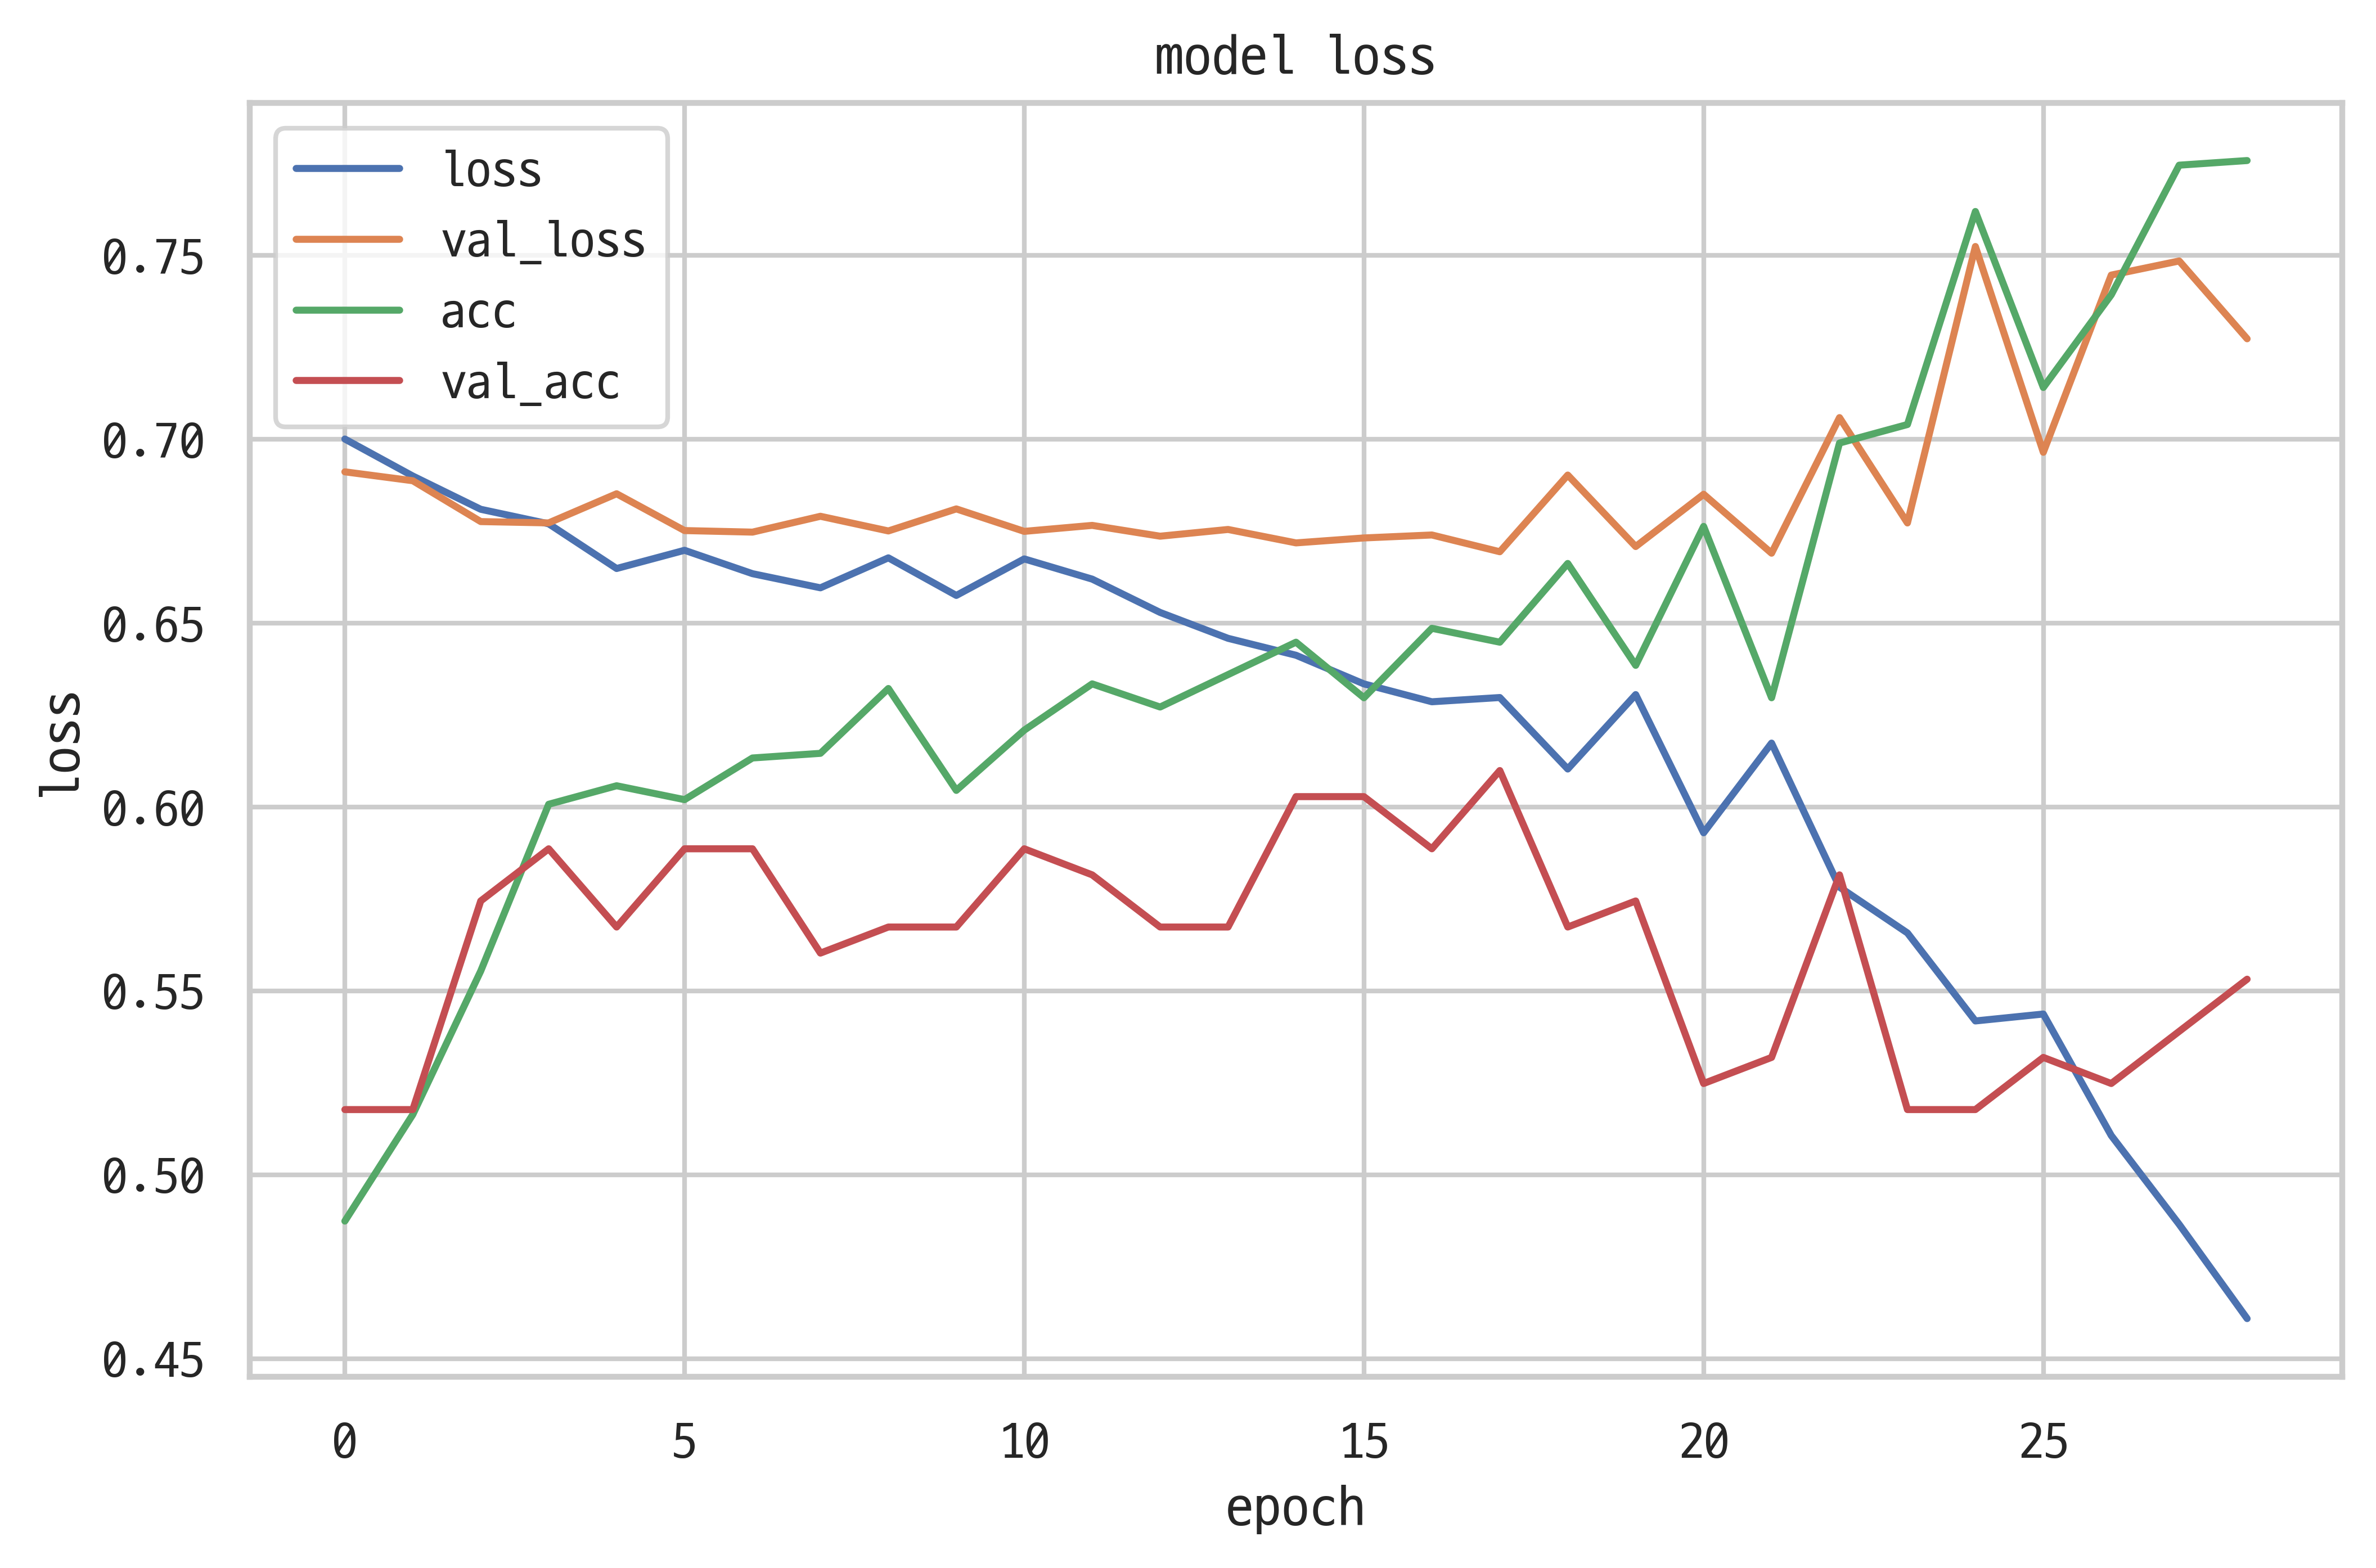

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()